In [61]:
import scipy as sps
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import multiprocessing as mp
palette = sns.color_palette("Paired")
size = 8
nsample = 1000

Let $X=(x_1, x_2,...,x_n)$ be a sample of $n$ observations a random variable following PDF $f(x; \lambda)$, in which $\lambda$ is an unknown parameter. The sample is assumed to be iid. The probability of observing such a sample is given by 

$$dP = \prod_{i=1}^n f(x_i; \lambda)dx_i = L(x_1,..., x_n;\lambda)\prod_{i=1}^n dx_i =L_X(\lambda)dX$$

Example: a Poisson variable is sampled $n$ times. The PDF contains the expected number of observations as the unknown parameter, given by 

$$f(x, \lambda) = \frac{ \lambda^x e^{-\lambda}}{x!}$$

The likelihood function is thus given by $$L(\lambda) = \prod_{i=1}^n \frac{ \lambda^{x_i} e^{-\lambda}}{x_i!} $$
It is usually more convenient to use the log likelihood function 
$$l = \log L = \sum_{i=1}^n \log( f(x_i, \lambda) ) $$

In [62]:
# simulate a poissonian dataset 

# mean signal
S = 5
# signal strength parameter
mu = 1

x = sps.stats.poisson.rvs(mu * S, size=nsample)

In [63]:
# log likehood function 

def loglikelihood_poisson(mu, x, S=S):
    return np.sum(sps.stats.poisson.logpmf(x, mu * S))

loglikelihood_poisson(1, x=x)

-2218.937004002334

In [64]:
# maximum likelihood estimation 

# analytic solution to the maximum likelihood estimation is the sample mean divided by the expected signal

def mle_poisson(x, S=S):
    return np.mean(x) / S

mle_poisson(x)

1.0246

In [65]:
# numerical solution 

def num_mle_poisson(x, S=S):
    return sps.optimize.minimize(lambda mu: -loglikelihood_poisson(mu, x, S), 1, options={'disp': False}).x[0]

num_mle_poisson(x)

1.0246000073994554

In [66]:
# expected value and variance of the maximum likelihood estimator

n_simulations = 1000000
n_process = 20

def simulate_and_estimate_poisson(mu, S=S, nsample=nsample):
    x = sps.stats.poisson.rvs(mu * S, size=nsample)
    return mle_poisson(x, S)

with mp.Pool(n_process) as pool:
    
    results = pool.map(simulate_and_estimate_poisson, [mu] * n_simulations)

results = np.array(results)
results

array([0.998 , 0.997 , 0.992 , ..., 0.9988, 1.0034, 1.0212])

In [76]:
# estimate the variance of the maximum likelihood estimator
mean_mle = np.mean(results)
var_mle = np.var(results, ddof=1)
mean_mle, var_mle

(0.9998359996, 0.00019894448545328534)

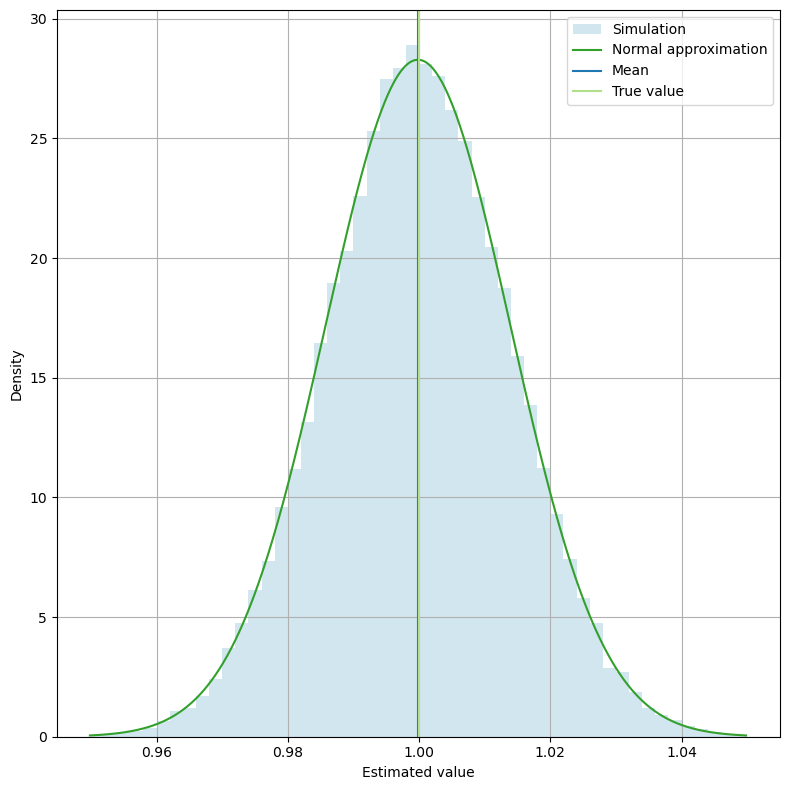

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(size, size))

margin = 0.05
x = np.linspace(mean_mle-margin,mean_mle+margin,1000)
ax.hist(results, bins=50, range=(1-margin,1+margin), color=palette[0], density=True, alpha=0.5, label='Simulation')
ax.plot(x, sps.stats.norm.pdf(x, loc=mean_mle, scale=np.sqrt(var_mle)), color=palette[3], label='Normal approximation')
ax.axvline(np.mean(results), color=palette[1], label='Mean')

ax.axvline(1, color=palette[2], label='True value')


ax.set_xlabel('Estimated value')
ax.set_ylabel('Density')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In this case, the MLE of $\lambda$ is unbiased. So the information inequality reads

$$\sigma^2(\hat{\lambda})\ge [I(\lambda)]^{-1}$$

In addition, the estimator is simply $\hat{\lambda} = \bar{x}/S$, while the log likelihood function reads

$$l(\lambda) = \log(\mu S)\left(\sum_i x_i\right)  - NS\mu - \sum_i x_i! = NS\log(\mu S)\hat{\lambda} - NS\mu - \sum_i x_i! $$

meaning it is first-order in $\hat{\lambda}$, so the equality is respected. Thus, $$\sigma^2(\hat{\lambda}) = [I(\lambda)] ^{-1} $$

We can evaluate exactly the Fischer information by differentiating the log-likelihood

$$l'(\mu) = \frac{NS\bar{x}}{\mu} - NS \Rightarrow (l'(\mu))^2 = N^2S^2 (\bar{x}/\mu - 1)^2 = N^2S^2 (\bar{x}^2/\mu^2 - 2 \bar{x}/\mu +1)$$

So that $$I(\mu)=E[l'(\mu)^2]=N^2S/\mu$$ and $$\sigma(\hat{\mu}) = \sqrt{\frac{\mu}{N^2S}} $$

In [86]:
std_information = np.sqrt(mean_mle / (nsample * S))
std_information

0.014140975918231387

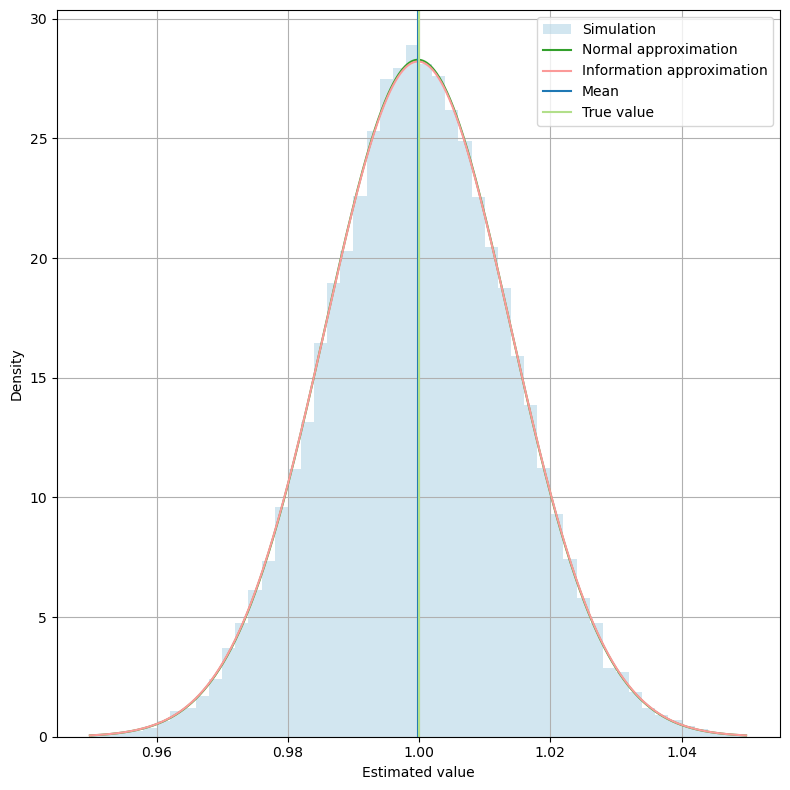

In [ ]:
# now we plot

from matplotlib import scale


fig, ax = plt.subplots(1, 1, figsize=(size, size))

margin = 0.05
x = np.linspace(mean_mle-margin,mean_mle+margin,1000)
ax.hist(results, bins=50, range=(1-margin,1+margin), color=palette[0], density=True, alpha=0.5, label='Simulation')
ax.plot(x, sps.stats.norm.pdf(x, loc=mean_mle, scale=np.sqrt(var_mle)), color=palette[3], label='Normal approximation')
ax.plot(x, sps.stats.norm.pdf(x, loc=mean_mle, scale=std_information), color=palette[4], label='Information approximation')
ax.axvline(np.mean(results), color=palette[1], label='Mean')

ax.axvline(1, color=palette[2], label='True value')


ax.set_xlabel('Estimated value')
ax.set_ylabel('Density')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()